In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

In [41]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import visualkeras as vk

In [3]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f",
                           class_labels=None):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0],
                                           display_labels=class_labels);
    axes[0].set_title("Raw Counts")

    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=class_labels);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_labels)
        return report_dict

def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False,
                                    class_labels=None):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data',
                                              class_labels=class_labels)



    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data',
                                             class_labels=class_labels)

In [4]:
# Checking the contents of xrays folder
data_dir = "C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays"
data_dir

'C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays'

In [5]:
# Gettting the list of folders from data dir
subfolders = os.listdir(data_dir)
subfolders

['covid', 'normal', 'pneumonia']

In [6]:
# Use glob to get all file paths in 'xrays' folder and its subfolders
img_files = glob.glob(os.path.join(data_dir , '**', '*'))
len(img_files)

6950

In [7]:
# Take a look at the first 5 filepaths
img_files[0:5]

['C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays\\covid\\001.jpeg',
 'C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays\\covid\\002.jpeg',
 'C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays\\covid\\003.jpeg',
 'C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays\\covid\\004.jpeg',
 'C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays\\covid\\005.jpeg']

In [8]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(751, 873, 3)

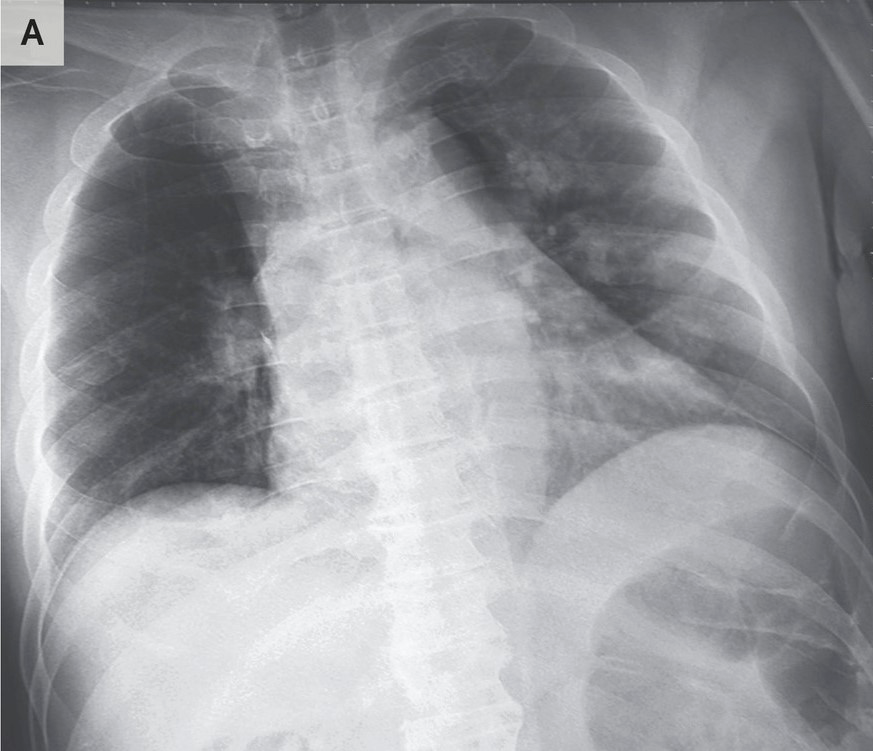

In [9]:
# Data can be converted back to image
array_to_img(img_data)

In [10]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 96
img_width = 96

In [12]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 6913 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [13]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

217

In [14]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 96, 96, 3])

In [15]:
# Preview y for first 5 of first batch
example_batch_y[0:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [16]:
# checking the class names
class_names = ds.class_names
class_names

['covid', 'normal', 'pneumonia']

In [17]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

3

In [18]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [19]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([96, 96, 3])

In [20]:
# Demo Unpacking shape
input_shape = [*input_shape]
input_shape

[96, 96, 3]

In [21]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1
# Calculate the number of batches for training and validation data
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 151 batches as training data
Use 43 batches as validation data
The remaining 23 batches will be used as test data.


In [22]:
# Use .take to slice out the number of batches
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)

151

In [23]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)

43

In [24]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)

23

In [25]:
# The original (non-take/non-skip) dataset contains the class_names
class_names  = ds.class_names
class_names

['covid', 'normal', 'pneumonia']

Building the Model
We will build and compile our model within a function.

Our model will include:

* Rescaling Layer
* Convolutional Layer #1
* Pooling Layer #1
* Convolutional Layer #2
* Pooling Layer #2
* Flattening Layer
* Output layer





The label_mode of our dataset is "categorial," so we will compile the model with 'categorical_cossentropy" for our loss function. We will include accuracy as an additional metric.

In [26]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [27]:
# Build the model
model1 = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0

### Fit the Model

In [28]:
import datetime as dt
# timing
start = dt.datetime.now()

# fit the neural network
epochs=5
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

end = dt.datetime.now()
dur = end-start
print(f"Training time: {dur}")

Epoch 1/5
151/151 [==============================] - 66s 425ms/step - loss: 0.6224 - accuracy: 0.7587 - val_loss: 0.5707 - val_accuracy: 0.8103
Epoch 2/5
151/151 [==============================] - 47s 311ms/step - loss: 0.4417 - accuracy: 0.8404 - val_loss: 0.4489 - val_accuracy: 0.8539
Epoch 3/5
151/151 [==============================] - 46s 304ms/step - loss: 0.3627 - accuracy: 0.8785 - val_loss: 0.3741 - val_accuracy: 0.8808
Epoch 4/5
151/151 [==============================] - 46s 297ms/step - loss: 0.3264 - accuracy: 0.8920 - val_loss: 0.3607 - val_accuracy: 0.8830
Epoch 5/5
151/151 [==============================] - 46s 298ms/step - loss: 0.2956 - accuracy: 0.9034 - val_loss: 0.4285 - val_accuracy: 0.8612
Training time: 0:04:11.246642


### Evaluate the Model


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.97      0.81      0.88      1591
      normal       0.75      0.99      0.85      1613
   pneumonia       0.99      0.82      0.90      1628

    accuracy                           0.87      4832
   macro avg       0.90      0.87      0.88      4832
weighted avg       0.90      0.87      0.88      4832



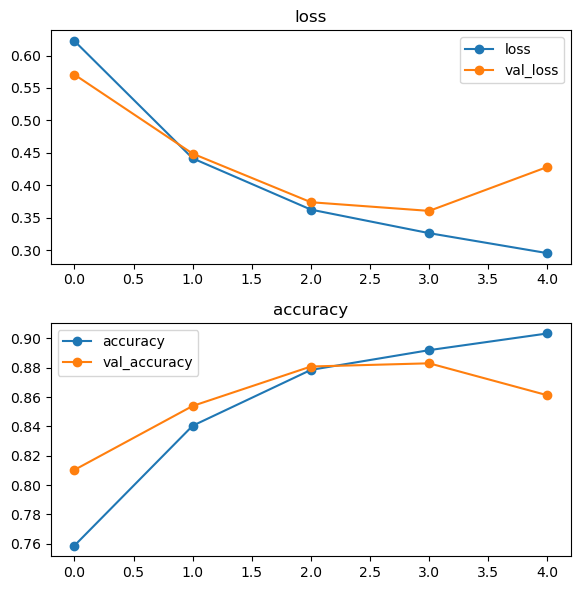

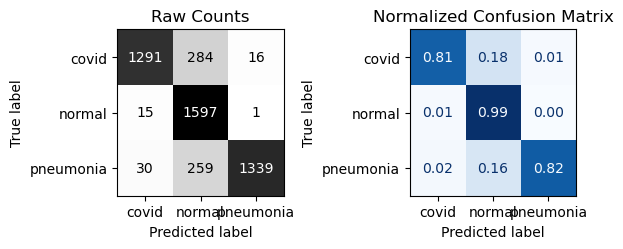

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       covid       0.95      0.77      0.85       456
      normal       0.73      0.97      0.84       453
   pneumonia       0.96      0.83      0.89       467

    accuracy                           0.86      1376
   macro avg       0.88      0.86      0.86      1376
weighted avg       0.88      0.86      0.86      1376



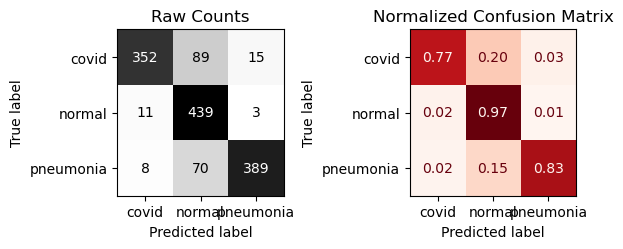

In [31]:
evaluate_classification_network(model1, X_train=train_ds, X_test=val_ds, history=history,
                                           figsize=(6,4), class_labels=class_names)


In [32]:
path = "C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays/model1_cnn()"
# default_model.save(path)

In [33]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0

### 2nd Model

In [34]:
# Use autotune to automatically determine best buffer sizes
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size

151

In [36]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# Call build function to create identical model
model2 = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)             

In [38]:
# See how long it takes to fit the optimized dataset
# timing
start = dt.datetime.now()
# fit the neural network
epochs=5
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Epoch 1/5
151/151 [==============================] - 49s 208ms/step - loss: 0.6424 - accuracy: 0.7425 - val_loss: 0.5218 - val_accuracy: 0.8052
Epoch 2/5
151/151 [==============================] - 10s 66ms/step - loss: 0.4556 - accuracy: 0.8375 - val_loss: 0.4202 - val_accuracy: 0.8706
Epoch 3/5
151/151 [==============================] - 10s 66ms/step - loss: 0.3685 - accuracy: 0.8775 - val_loss: 0.3785 - val_accuracy: 0.8830
Epoch 4/5
151/151 [==============================] - 10s 68ms/step - loss: 0.3227 - accuracy: 0.8924 - val_loss: 0.3747 - val_accuracy: 0.8823
Epoch 5/5
151/151 [==============================] - 10s 69ms/step - loss: 0.2865 - accuracy: 0.9065 - val_loss: 0.3595 - val_accuracy: 0.8852
Training time: 0:01:29.851243


3rd Model

In [ ]:
evaluate_classification_network(model2, X_train=train_ds, X_test=val_ds, history=history,
                                           figsize=(6,4), class_labels=class_names)

In [39]:
def build_model3():

    model = models.Sequential(name="Model3")
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))

    # Convolutional layer #1
    model.add( layers.Conv2D(filters=16,  kernel_size=3, padding='same') )
    # Pooling layer #1
    model.add( layers.MaxPooling2D(pool_size=2, strides=1))

    # Convolutional layer #2
    model.add( layers.Conv2D(filters=16, kernel_size=3, padding='same'))
    # Pooling layer #2
    model.add(layers.MaxPooling2D(pool_size=2, strides=1))

    # Flattening layer
    model.add(layers.Flatten())
    # # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")
    )

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    model.summary()
    return model

Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 95, 95, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 94, 94, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 141376)            0    

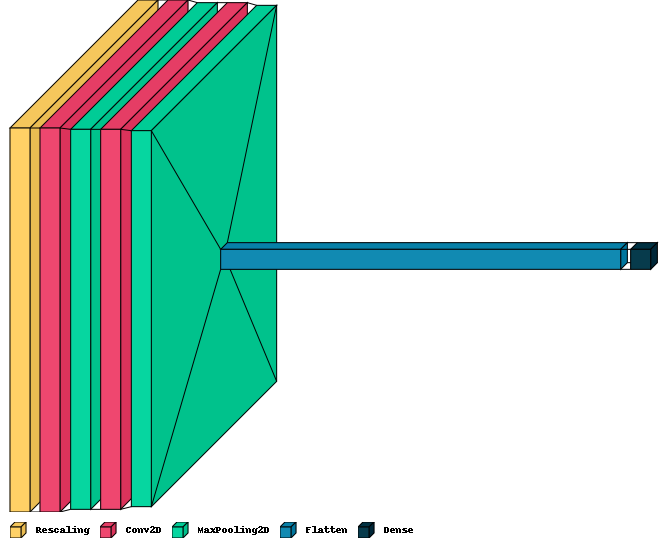

In [42]:
# Build model and visualize
model3 = build_model3()
vk.layered_view(model3, legend=True)

In [43]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [44]:
# Build new model and fit
model3 = build_model3()
history = model3.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)

Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 95, 95, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 95, 95, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 94, 94, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 141376)            0    


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1598
           1       0.94      0.95      0.95      1611
           2       0.94      0.96      0.95      1623

    accuracy                           0.95      4832
   macro avg       0.95      0.95      0.95      4832
weighted avg       0.95      0.95      0.95      4832



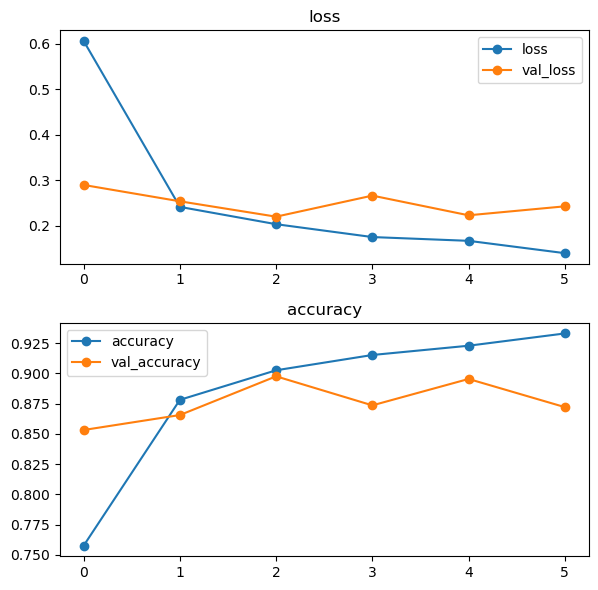

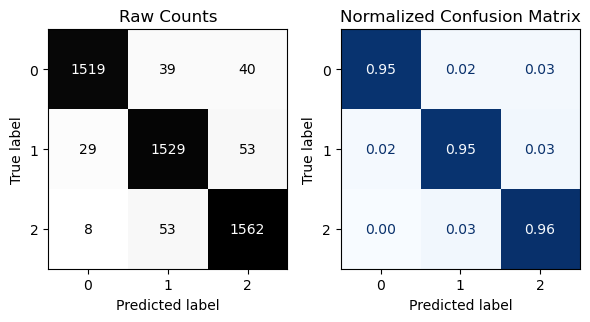

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       216
           1       0.87      0.87      0.87       259
           2       0.86      0.91      0.88       230

    accuracy                           0.87       705
   macro avg       0.88      0.87      0.87       705
weighted avg       0.87      0.87      0.87       705



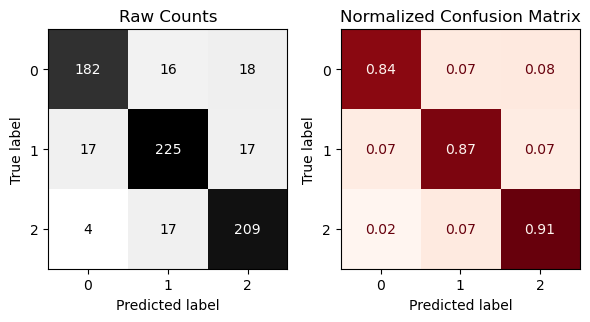

In [45]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    model3, X_train=train_ds, X_test=test_ds, history=history);

### Transfer Learning Model

In [69]:
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications.resnet import ResNet101

In [70]:
## Load the model.

pretrained = tf.keras.applications.ResNet101(input_shape=input_shape,
                                     include_top=False,
                                     weights='imagenet',
                                     classes=num_classes)

pretrained.trainable=False


In [71]:
# !pip install --force-reinstall -v "pillow<=9.5.0"

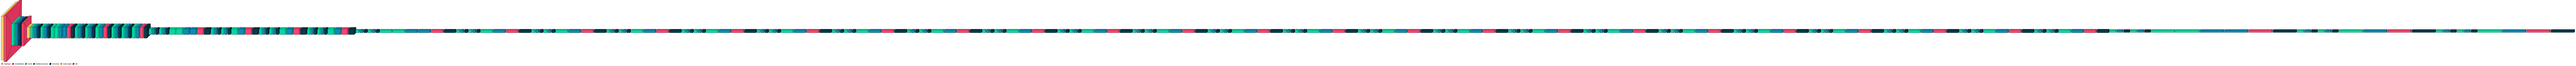

In [72]:
vk.layered_view(pretrained, legend=True)

In [77]:
def build_transfer_model():

    ## Initialize Model
    model = models.Sequential()

    ## Add input layer
    model.add(layers.Input(shape=input_shape, name='input'))

       # Define lambda preprocessing layer
    lambda_layer = tf.keras.layers.Lambda(tf.keras.applications.ResNet101.preprocess_input, 
                                      name='preprocess_input')

    ## Add the pretrained layers
    model.add(pretrained)

    ## Flatten the Data
    model.add(layers.Flatten())

    ## Add a dropout layer for regularization
    model.add(layers.Dense(32))
    model.add(layers.Dense(32))

    ## Add the output layer
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    ## Complile the model and return it.
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

    display(model.summary())
    return model


In [89]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import Sequential

def build_transfer_model(pretrained):
    # Initialize ResNet101 base model
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the ResNet101 base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create the model
    model = Sequential()

    # Add the lambda preprocessing layer
    model.add(layers.Input(shape=input_shape, name='input'))
    lambda_layer = tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input, name='preprocess_input')
    model.add(lambda_layer)

    # Add the pretrained ResNet101 layers
    model.add(pretrained)

    # Flatten the data
    model.add(layers.Flatten())

    # Add dropout layers for regularization
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Add the output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))
    

    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    model.summary()
    
    return model

In [90]:
# Build new model and fit
transfer_model = build_transfer_model(pretrained)
history = transfer_model.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 resnet101 (Functional)      (None, 3, 3, 2048)        42658176  
                                                                 
 flatten_6 (Flatten)         (None, 18432)             0         
                                                                 
 dense_7 (Dense)             (None, 32)                589856    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)               


- Evaluating Network...


C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1598
           1       0.48      0.98      0.64      1611
           2       0.97      0.91      0.94      1623

    accuracy                           0.63      4832
   macro avg       0.48      0.63      0.53      4832
weighted avg       0.48      0.63      0.53      4832



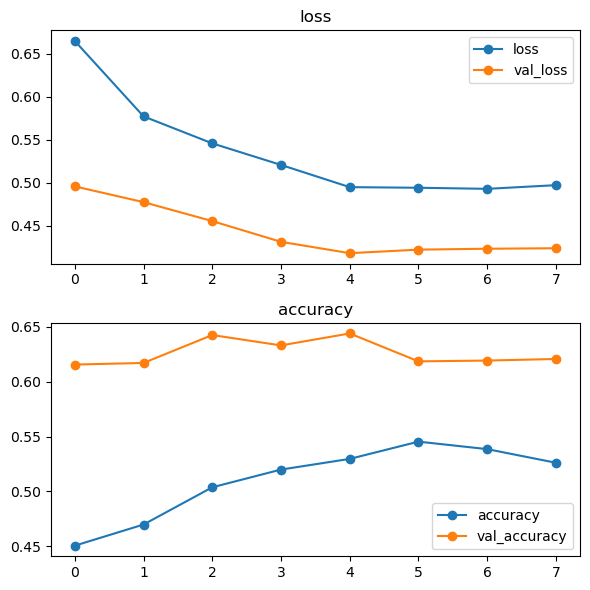

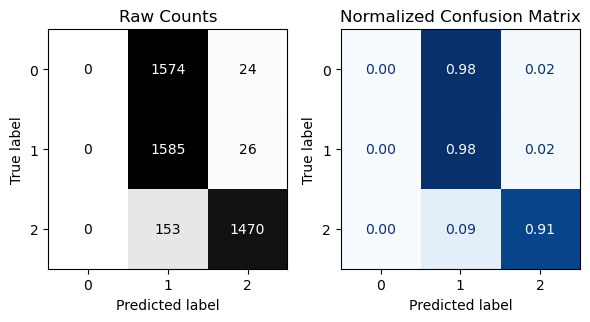

C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmus

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.51      0.97      0.67       259
           2       0.95      0.90      0.92       230

    accuracy                           0.65       705
   macro avg       0.49      0.62      0.53       705
weighted avg       0.50      0.65      0.55       705



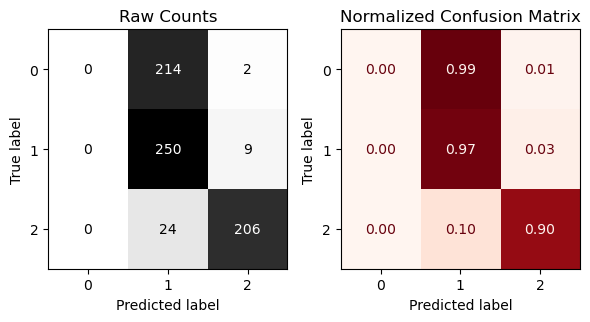

C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dmusl\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    transfer_model, X_train=train_ds, X_test=test_ds, history=history);

In [93]:
## Save the model

transfer_model.save('C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays/transfer_model')

INFO:tensorflow:Assets written to: C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays/transfer_model\assets


INFO:tensorflow:Assets written to: C:/Users/dmusl/OneDrive/Pictures/Data/xrays/xrays/transfer_model\assets
